# Modelos



## Introducción a los Modelos de Machine Learning
En el análisis de datos, los modelos de Machine Learning nos permiten identificar patrones y hacer predicciones basadas en datos históricos. Uno de los modelos más interpretables y eficientes para problemas de clasificación es el **Árbol de Decisión** (*Decision Tree*). Este modelo divide los datos en diferentes ramas según criterios de segmentación, facilitando la interpretación de los factores que influyen en la toma de decisiones.

## Objetivo del Análisis
Este estudio busca entender los factores que influyen en la compra de **múltiples coches** en comparación con la compra de un solo vehículo. La meta es desarrollar un modelo que permita predecir si un cliente comprará **uno o más de un coche**, y con ello, generar estrategias que incentiven la compra de múltiples unidades.

## Variable Objetivo (*Target*)
La variable de interés en este modelo es **"Mas_1_coche"**, la cual toma dos posibles valores:
- `0`: El cliente compró **un solo coche**.
- `1`: El cliente compró **más de un coche**.

## Variables Predictoras (*Features*)
Para predecir la variable objetivo, utilizaremos un conjunto de variables predictoras que incluyen características del cliente, del vehículo y del historial de compra. Estas variables serán seleccionadas en base a su relevancia para mejorar el rendimiento del modelo.




## Importación de librerías

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from itertools import product
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, roc_auc_score,
    roc_curve, precision_recall_curve, precision_score, recall_score, f1_score
)
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import (
    train_test_split, cross_val_score, learning_curve, validation_curve
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from tabulate import tabulate
from sklearn.model_selection import GridSearchCV

# Importar métricas y validación cruzada
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier



In [4]:
df = pd.read_csv('../data/Propensity_Processed.csv')
df.head()

,PRODUCTO,TIPO_CARROCERIA,COMBUSTIBLE,Potencia,TRANS,FORMA_PAGO,ESTADO_CIVIL,GENERO,OcupaciOn,PROVINCIA,...,Zona_Renta,REV_Garantia,Averia_grave,QUEJA_CAC,COSTE_VENTA,km_anno,Mas_1_coche,Revisiones,Edad_Cliente,Tiempo
0,0,0,0,0.0,1,0,0,1,1,4,...,1.0,0,3.0,1,2892,0,0,2,18,0
1,0,0,0,0.0,1,0,0,0,1,47,...,1.0,1,0.0,0,1376,7187,0,2,53,0
2,0,0,0,0.0,1,3,0,1,1,30,...,2.0,0,0.0,0,1376,0,1,4,21,3
3,0,0,0,0.0,1,2,0,0,1,32,...,2.0,1,3.0,1,2015,7256,1,4,48,5
4,0,0,0,0.0,1,2,0,0,2,41,...,3.0,0,0.0,0,1818,0,1,3,21,3


## Entrenamiendo del modelo

In [5]:
X = df.drop(columns=['Mas_1_coche', 'Tiempo'])  # Eliminamos también la columna 'Tiempo' por su alta correlación
y = df['Mas_1_coche']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
y_train.value_counts()

Mas_1_coche
0    32671
1    13565
Name: count, dtype: int64

In [8]:
y_test.value_counts()

Mas_1_coche
0    8279
1    3280
Name: count, dtype: int64

In [9]:
rf_model = RandomForestClassifier(
                                    random_state=42,
                                    n_estimators=100,
                                    min_samples_split=5)
rf_model.fit(X_train, y_train)

RandomForestClassifier(min_samples_split=5, random_state=42)

In [9]:
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='accuracy')
cv_scores

array([0.82969291, 0.82264518, 0.82405104, 0.82989078, 0.82588948])

In [10]:
print("Train set score (Accuracy) =", rf_model.score(X_train, y_train))
print("Test set score (Accuracy) =", rf_model.score(X_test, y_test))

conf_mat = confusion_matrix(y_test, rf_model.predict(X_test))

num_classes = conf_mat.shape[0]

print(tabulate(
    conf_mat,
    headers=[f'Pred Class {i}' for i in range(num_classes)],
    showindex=[f'Real Class {i}' for i in range(num_classes)],
    tablefmt='fancy_grid'
))

print("\nClassification Report:")
print(classification_report(y_test, rf_model.predict(X_test)))

Train set score (Accuracy) = 0.9840600397958301
Test set score (Accuracy) = 0.833982178389134
╒══════════════╤════════════════╤════════════════╕
│              │   Pred Class 0 │   Pred Class 1 │
╞══════════════╪════════════════╪════════════════╡
│ Real Class 0 │           7592 │            687 │
├──────────────┼────────────────┼────────────────┤
│ Real Class 1 │           1232 │           2048 │
╘══════════════╧════════════════╧════════════════╛

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.92      0.89      8279
           1       0.75      0.62      0.68      3280

    accuracy                           0.83     11559
   macro avg       0.80      0.77      0.78     11559
weighted avg       0.83      0.83      0.83     11559



## RANDOMFOREST

In [11]:
param_grid = {
    'criterion': ['entropy'],  
    'n_estimators': [100, 300, 500],  
    'max_depth': [10, 50, 100, None],  
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [3, 5, 10],  
    'max_features': ['sqrt'],  
    'bootstrap': [True],  
    'class_weight': ['balanced', 'balanced_subsample'],  
    'min_weight_fraction_leaf': [0.0],  
    'max_leaf_nodes': [None],  
    'warm_start': [False]
}

results = []

# Iterar sobre todas las combinaciones de hiperparámetros
for params in product(*param_grid.values()):
    criterion, n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features, bootstrap, class_weight, min_weight_fraction_leaf, max_leaf_nodes, warm_start = params
    
    # Construir el modelo RandomForest con los nuevos parámetros
    model = RandomForestClassifier(
        criterion=criterion, 
        n_estimators=n_estimators,
        max_depth=max_depth, 
        min_samples_split=min_samples_split, 
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        bootstrap=bootstrap,
        class_weight=class_weight,
        min_weight_fraction_leaf=min_weight_fraction_leaf,
        max_leaf_nodes=max_leaf_nodes,
        warm_start=warm_start,
        random_state=42
    )
    
    # Entrenar el modelo
    model.fit(X_train, y_train)
    
    # Predecir probabilidades en el conjunto de prueba
    y_pred_proba = model.predict_proba(X_test)[:, 1]  
    y_pred = (y_pred_proba > 0.45).astype(int)  # Se ajusta el umbral

    # Calcular métricas
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')  
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    # Validación cruzada
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='recall')  
    mean_cv_score = np.mean(cv_scores)
    
    # Guardar resultados
    results.append({
        'criterion': criterion,
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'accuracy': accuracy,
        'f1_score': f1,
        'recall': recall,  
        'roc_auc': roc_auc,
        'cv_recall': mean_cv_score  
    })

# Convertir a DataFrame y ordenar por recall
results_df = pd.DataFrame(results).sort_values(by=['recall', 'f1_score'], ascending=False)

# Mostrar los mejores modelos optimizados para recall
display(results_df.head(5))

KeyboardInterrupt: 

## Boost

### AdaBoost

In [12]:


# Definir el modelo base
model = AdaBoostClassifier()

# Definir los hiperparámetros para la búsqueda
param_grid = {
    'n_estimators': [50, 100, 250],  # Reducimos para acelerar
    'learning_rate': [0.05, 0.2],  
    'algorithm': ['SAMME.R'],
    'random_state': [42]  # Se añade el random_state
}

# Configurar GridSearchCV
grid_search = GridSearchCV(
    model,
    param_grid,
    cv=5,  # Validación cruzada con 5 folds
    scoring='recall_weighted',  # Optimizar para recall
    n_jobs=-1,  # Paralelizar en todos los núcleos
    verbose=2  # Mostrar progreso
)

# Entrenar el modelo con la búsqueda de hiperparámetros
grid_search.fit(X_train, y_train)

# Obtener los mejores parámetros
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Hacer predicciones en el conjunto de prueba
y_pred = best_model.predict(X_test)

# Calcular métricas de evaluación
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

# Guardar resultados en un DataFrame
results_ada_df = pd.DataFrame([{
    'model': "AdaBoost",
    'best_params': best_params,
    'accuracy': accuracy,
    'f1_score': f1,
    'recall': recall,
    'cv_score': grid_search.best_score_,
    'train_score': best_model.score(X_train, y_train)
}])

# Mostrar los resultados
display(results_ada_df)


Fitting 5 folds for each of 6 candidates, totalling 30 fits


ValueError: 
All the 30 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\lucia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\lucia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\lucia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\lucia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\_param_validation.py", line 98, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'algorithm' parameter of AdaBoostClassifier must be a str among {'SAMME'}. Got 'SAMME.R' instead.


### Gradient bosting

In [15]:
# Parámetros específicos para Gradient Boosting
param_grid = {
    'loss': ['log_loss'],
    'learning_rate': [0.05, 0.2],
    'n_estimators': [500],
    'subsample': [1.0],
    'criterion': ['friedman_mse'],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'max_depth': [3],
    'random_state': [42],
    'max_features': ['sqrt']
}

# Almacenar resultados
results_gb = []

for params in product(*param_grid.values()):
    param_dict = dict(zip(param_grid.keys(), params))
    
    # Instanciar y entrenar el modelo
    model = GradientBoostingClassifier(**param_dict)
    model.fit(X_train, y_train)
    
    # Predecir
    y_pred = model.predict(X_test)
    
    # Calcular métricas
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    
    # Validación cruzada
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    mean_cv_score = np.mean(cv_scores)
    
    # Calcular Train Score
    train_score = model.score(X_train, y_train)
    
    # Guardar resultados
    param_dict.update({
        'model': "GradientBoosting",
        'accuracy': accuracy,
        'f1_score': f1,
        'recall': recall,
        'cv_score': mean_cv_score,
        'train_score': train_score
    })
    results_gb.append(param_dict)

# Convertir a DataFrame y mostrar resultados
results_gb_df = pd.DataFrame(results_gb)
display(results_gb_df.sort_values(by=['f1_score', 'accuracy'], ascending=False).head(3))


,loss,learning_rate,n_estimators,subsample,criterion,min_samples_split,min_samples_leaf,max_depth,random_state,max_features,model,accuracy,f1_score,recall,cv_score,train_score
1,log_loss,0.20,500,1.0,friedman_mse,2,1,3,42,sqrt,GradientBoosting,0.832252,0.826966,0.832252,0.827861,0.841530
0,log_loss,0.05,500,1.0,friedman_mse,2,1,3,42,sqrt,GradientBoosting,0.814171,0.804409,0.814171,0.811035,0.813825


### XGBoost

In [25]:
# Definir la ruta dentro del repositorio
repo_dir = os.getcwd()  # Obtiene el directorio de trabajo actual
model_dir = os.path.join(repo_dir, "models")
os.makedirs(model_dir, exist_ok=True)

# Parámetros específicos para XGBoost
param_grid = {
    'learning_rate': [0.05, 0.2],
    'n_estimators': [500],
    'max_depth': [3],
    'min_child_weight': [1],
    'subsample': [1.0],
    'colsample_bytree': [0.8],
    'reg_alpha': [0],
    'reg_lambda': [1],
    'gamma': [0],
    'scale_pos_weight': [1],
    'base_score': [0.5],
    'random_state': [42],
    'verbosity': [1]
}

# Almacenar resultados
results_xgb = []
best_model = None
best_f1_score = 0

for params in product(*param_grid.values()):
    param_dict = dict(zip(param_grid.keys(), params))
    
    # Instanciar y entrenar el modelo
    model = XGBClassifier(**param_dict)
    model.fit(X_train, y_train)
    
    # Predecir
    y_pred = model.predict(X_test)
    
    # Calcular métricas
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    
    # Validación cruzada
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    mean_cv_score = np.mean(cv_scores)
    
    # Calcular Train Score
    train_score = model.score(X_train, y_train)
    
    # Guardar resultados
    param_dict.update({
        'model': "XGBoost",
        'accuracy': accuracy,
        'f1_score': f1,
        'recall': recall,
        'cv_score': mean_cv_score,
        'train_score': train_score
    })
    results_xgb.append(param_dict)

    # Guardar el mejor modelo basado en f1_score
    if f1 > best_f1_score:
        best_f1_score = f1
        best_model = model
        best_params = param_dict

# Convertir a DataFrame y mostrar resultados
results_xgb_df = pd.DataFrame(results_xgb)
display(results_xgb_df.sort_values(by=['f1_score', 'accuracy'], ascending=False).head(3))

# Guardar el mejor modelo en la carpeta 'models' dentro del repositorio
model_path = os.path.join(model_dir, "best_xgboost_model.pkl")
joblib.dump(best_model, model_path)

# Verificar si se guardó correctamente
if os.path.exists(model_path):
    print(f"✅ Mejor modelo guardado en {model_path} con F1-score de {best_f1_score:.4f}")
else:
    print("❌ Error: No se pudo guardar el modelo.")


,learning_rate,n_estimators,max_depth,min_child_weight,subsample,colsample_bytree,reg_alpha,reg_lambda,gamma,scale_pos_weight,base_score,random_state,verbosity,model,accuracy,f1_score,recall,cv_score,train_score
1,0.20,500,3,1,1.0,0.8,0,1,0,1,0.5,42,1,XGBoost,0.835193,0.830699,0.835193,0.830262,0.848495
0,0.05,500,3,1,1.0,0.8,0,1,0,1,0.5,42,1,XGBoost,0.822649,0.815069,0.822649,0.817869,0.822736


✅ Mejor modelo guardado en c:\Users\lucia\OneDrive\Documentos\propensity_trainn\notebooks\models\best_xgboost_model.pkl con F1-score de 0.8307


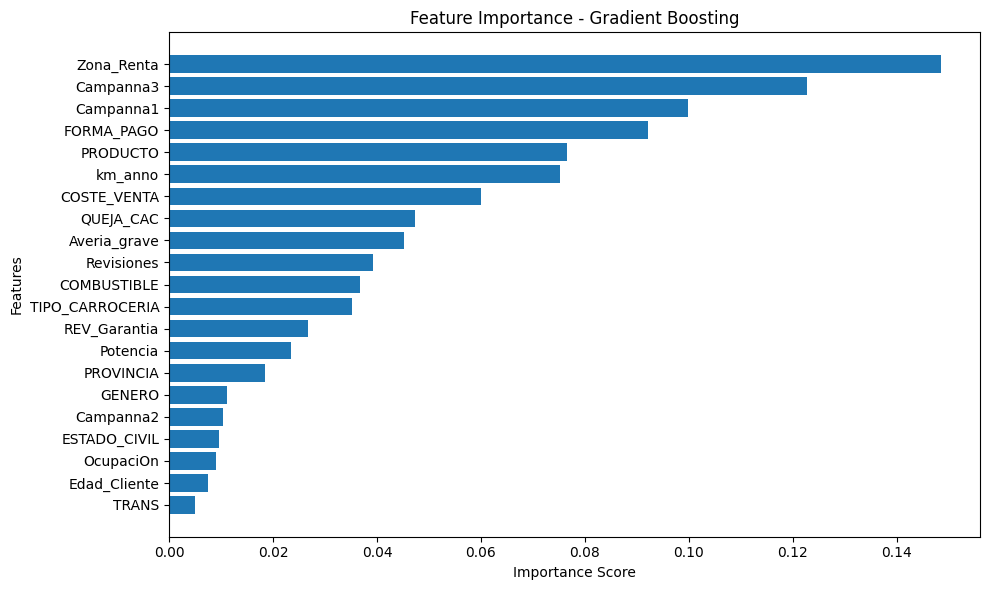

In [26]:
feature_importances = model.feature_importances_

importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], align='center')
plt.gca().invert_yaxis()
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance - Gradient Boosting')
plt.tight_layout()
plt.show()

In [27]:
# Predicciones en el conjunto de prueba.
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

In [28]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.92      0.89      8279
           1       0.75      0.63      0.69      3280

    accuracy                           0.84     11559
   macro avg       0.81      0.77      0.79     11559
weighted avg       0.83      0.84      0.83     11559



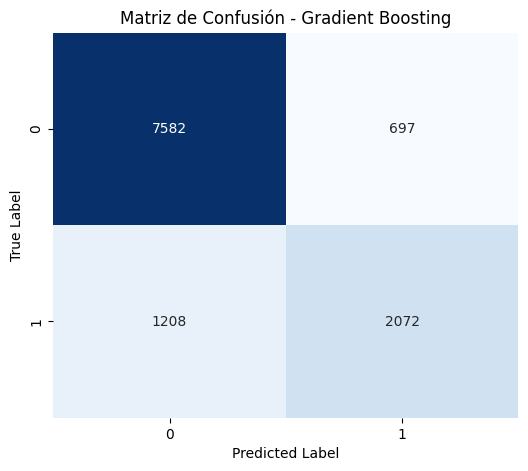

In [29]:
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Matriz de Confusión - Gradient Boosting')
plt.show()

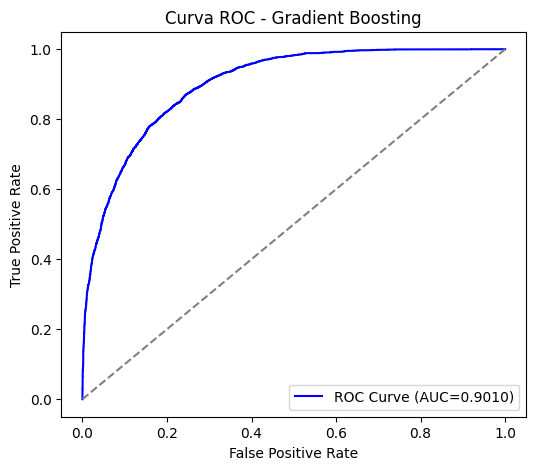

In [32]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC={roc_auc_score(y_test, y_pred_proba):.4f})", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Curva ROC - Gradient Boosting')
plt.legend()
plt.show()

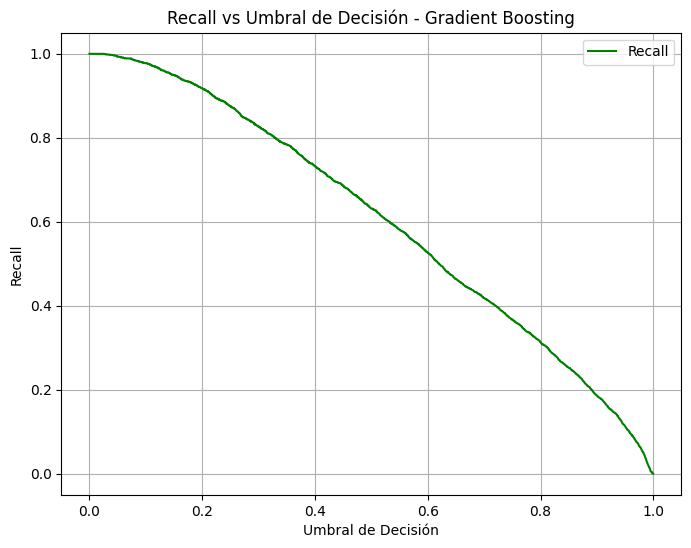

In [31]:
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilidades de clase 1

# Calcular Precision-Recall para diferentes umbrales
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Graficar Recall vs Umbral de Decisión
plt.figure(figsize=(8, 6))
plt.plot(thresholds, recalls[:-1], label='Recall', color='green')
plt.xlabel('Umbral de Decisión')
plt.ylabel('Recall')
plt.title('Recall vs Umbral de Decisión - Gradient Boosting')
plt.grid(True)
plt.legend()
plt.show()

## Aplicación de los Modelos al Input

In [33]:
file_path = "../data/Propensity_input.csv"
df = pd.read_csv(file_path, index_col=0)

In [34]:
df.head()

,PRODUCTO,TIPO_CARROCERIA,COMBUSTIBLE,TRANS,Potencia,FORMA_PAGO,ESTADO_CIVIL,GENERO,OcupaciOn,PROVINCIA,...,Campanna2,Campanna3,Zona_Renta,REV_Garantia,QUEJA_CAC,Averia_grave,COSTE_VENTA,km_anno,Revisiones,Edad_Cliente
CODE,,,,,,,,,,,,,,,,,,,,,
CLIX1,0,0,0,1,0.0,3,0,1,1,26,...,0,0,2.0,0,0,0.0,2892,0,1,20
CLIX2,0,0,0,1,0.0,3,3,1,1,38,...,0,0,3.0,1,0,1.0,2892,17967,1,55
CLIX3,0,0,0,1,0.0,0,3,0,1,46,...,0,0,1.0,0,0,2.0,1376,0,1,18
CLIX4,0,0,0,1,0.0,0,0,0,1,47,...,0,0,3.0,1,0,0.0,2594,6219,1,37
CLIX5,0,0,0,1,0.0,3,0,0,1,8,...,0,0,1.0,0,1,3.0,1376,0,1,21


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10991 entries, CLIX1 to CLIX11484
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PRODUCTO         10991 non-null  int64  
 1   TIPO_CARROCERIA  10991 non-null  int64  
 2   COMBUSTIBLE      10991 non-null  int64  
 3   TRANS            10991 non-null  int64  
 4   Potencia         10991 non-null  float64
 5   FORMA_PAGO       10991 non-null  int64  
 6   ESTADO_CIVIL     10991 non-null  int64  
 7   GENERO           10991 non-null  int64  
 8   OcupaciOn        10991 non-null  int64  
 9   PROVINCIA        10991 non-null  int64  
 10  Campanna1        10991 non-null  int64  
 11  Campanna2        10991 non-null  int64  
 12  Campanna3        10991 non-null  int64  
 13  Zona_Renta       10991 non-null  float64
 14  REV_Garantia     10991 non-null  int64  
 15  QUEJA_CAC        10991 non-null  int64  
 16  Averia_grave     10991 non-null  float64
 17  COSTE_VEN

In [37]:
modelo = joblib.load("../notebooks/models/best_xgboost_model.pkl")

# Ver qué columnas fueron usadas en el entrenamiento
features_esperadas = modelo.feature_names_in_
print("Columnas esperadas por el modelo:", features_esperadas)

Columnas esperadas por el modelo: ['PRODUCTO' 'TIPO_CARROCERIA' 'COMBUSTIBLE' 'Potencia' 'TRANS'
 'FORMA_PAGO' 'ESTADO_CIVIL' 'GENERO' 'OcupaciOn' 'PROVINCIA' 'Campanna1'
 'Campanna2' 'Campanna3' 'Zona_Renta' 'REV_Garantia' 'Averia_grave'
 'QUEJA_CAC' 'COSTE_VENTA' 'km_anno' 'Revisiones' 'Edad_Cliente']


In [39]:
df = df[features_esperadas]  # Reordena las columnas según el modelo


In [40]:
print("Columnas en el modelo:", set(features_esperadas))
print("Columnas en df:", set(df.columns))
print("Diferencias:", set(features_esperadas) - set(df.columns), set(df.columns) - set(features_esperadas))


Columnas en el modelo: {np.str_('TRANS'), np.str_('FORMA_PAGO'), np.str_('Campanna3'), np.str_('Campanna2'), np.str_('Zona_Renta'), np.str_('km_anno'), np.str_('COMBUSTIBLE'), np.str_('GENERO'), np.str_('REV_Garantia'), np.str_('Averia_grave'), np.str_('TIPO_CARROCERIA'), np.str_('COSTE_VENTA'), np.str_('Campanna1'), np.str_('PROVINCIA'), np.str_('PRODUCTO'), np.str_('Potencia'), np.str_('QUEJA_CAC'), np.str_('ESTADO_CIVIL'), np.str_('OcupaciOn'), np.str_('Edad_Cliente'), np.str_('Revisiones')}
Columnas en df: {'TRANS', 'FORMA_PAGO', 'Campanna3', 'Campanna2', 'Zona_Renta', 'km_anno', 'COMBUSTIBLE', 'GENERO', 'REV_Garantia', 'Averia_grave', 'TIPO_CARROCERIA', 'COSTE_VENTA', 'Campanna1', 'PROVINCIA', 'PRODUCTO', 'Potencia', 'QUEJA_CAC', 'ESTADO_CIVIL', 'OcupaciOn', 'Edad_Cliente', 'Revisiones'}
Diferencias: set() set()


In [41]:
print(df.dtypes)


PRODUCTO             int64
TIPO_CARROCERIA      int64
COMBUSTIBLE          int64
Potencia           float64
TRANS                int64
FORMA_PAGO           int64
ESTADO_CIVIL         int64
GENERO               int64
OcupaciOn            int64
PROVINCIA            int64
Campanna1            int64
Campanna2            int64
Campanna3            int64
Zona_Renta         float64
REV_Garantia         int64
Averia_grave       float64
QUEJA_CAC            int64
COSTE_VENTA          int64
km_anno              int64
Revisiones           int64
Edad_Cliente         int64
dtype: object


In [44]:
# Convertir a tipo 'category'
cat_columns = ["PRODUCTO", "TIPO_CARROCERIA", "COMBUSTIBLE", "TRANS", "FORMA_PAGO", 
               "ESTADO_CIVIL", "GENERO", "OcupaciOn", "PROVINCIA"]

df[cat_columns] = df[cat_columns].astype("category")

In [45]:
# Aplicar el modelo a los datos corregidos
y_pred_proba = modelo.predict_proba(df)[:, 1]  

# Agregar la probabilidad al DataFrame original (sin eliminar CODE)
df["Propension_Compra"] = y_pred_proba
df["Predicción_Compra"] = (y_pred_proba >= 0.40).astype(int)

In [46]:
df.head(5)

,PRODUCTO,TIPO_CARROCERIA,COMBUSTIBLE,Potencia,TRANS,FORMA_PAGO,ESTADO_CIVIL,GENERO,OcupaciOn,PROVINCIA,...,Zona_Renta,REV_Garantia,Averia_grave,QUEJA_CAC,COSTE_VENTA,km_anno,Revisiones,Edad_Cliente,Propension_Compra,Predicción_Compra
CODE,,,,,,,,,,,,,,,,,,,,,
CLIX1,0,0,0,0.0,1,3,0,1,1,26,...,2.0,0,0.0,0,2892,0,1,20,0.750055,1
CLIX2,0,0,0,0.0,1,3,3,1,1,38,...,3.0,1,1.0,0,2892,17967,1,55,0.897437,1
CLIX3,0,0,0,0.0,1,0,3,0,1,46,...,1.0,0,2.0,0,1376,0,1,18,0.001681,0
CLIX4,0,0,0,0.0,1,0,0,0,1,47,...,3.0,1,0.0,0,2594,6219,1,37,0.462404,1
CLIX5,0,0,0,0.0,1,3,0,0,1,8,...,1.0,0,3.0,1,1376,0,1,21,0.052493,0


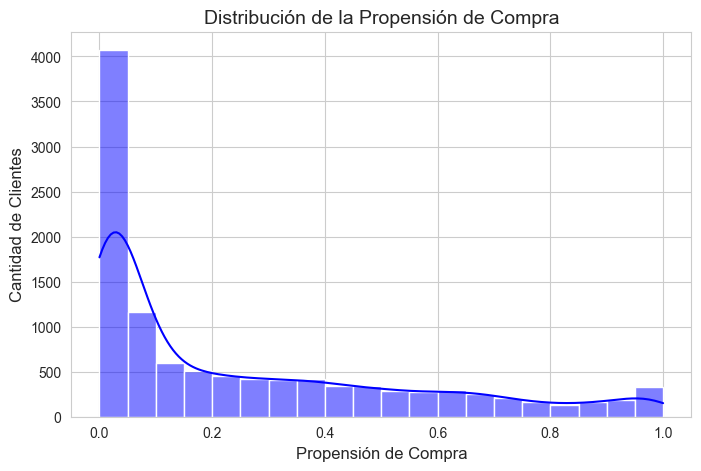

In [47]:
# Configurar el estilo de los gráficos
sns.set_style("whitegrid")

# 📊 1️⃣ Histograma: Distribución de la Propensión de Compra
plt.figure(figsize=(8,5))
sns.histplot(df["Propension_Compra"], bins=20, kde=True, color="blue")
plt.title("Distribución de la Propensión de Compra", fontsize=14)
plt.xlabel("Propensión de Compra", fontsize=12)
plt.ylabel("Cantidad de Clientes", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [51]:
# Obtener las columnas que el modelo espera
feature_names = modelo.get_booster().feature_names

# Verificar si las columnas coinciden
print("Columnas esperadas por el modelo:", feature_names)
print("Columnas del DataFrame actual:", df.columns.tolist())

# Reordenar las columnas según las que el modelo espera
df = df[feature_names]

# Convertir a tipo numérico/categórico si es necesario
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].astype('category')

# Intentar predecir nuevamente
df["Propension_Compra"] = modelo.predict_proba(df)[:, 1] * 100


Columnas esperadas por el modelo: ['PRODUCTO', 'TIPO_CARROCERIA', 'COMBUSTIBLE', 'Potencia', 'TRANS', 'FORMA_PAGO', 'ESTADO_CIVIL', 'GENERO', 'OcupaciOn', 'PROVINCIA', 'Campanna1', 'Campanna2', 'Campanna3', 'Zona_Renta', 'REV_Garantia', 'Averia_grave', 'QUEJA_CAC', 'COSTE_VENTA', 'km_anno', 'Revisiones', 'Edad_Cliente']
Columnas del DataFrame actual: ['PRODUCTO', 'TIPO_CARROCERIA', 'COMBUSTIBLE', 'TRANS', 'Potencia', 'FORMA_PAGO', 'ESTADO_CIVIL', 'GENERO', 'OcupaciOn', 'PROVINCIA', 'Campanna1', 'Campanna2', 'Campanna3', 'Zona_Renta', 'REV_Garantia', 'QUEJA_CAC', 'Averia_grave', 'COSTE_VENTA', 'km_anno', 'Revisiones', 'Edad_Cliente']


C:\Users\lucia\AppData\Local\Temp\ipykernel_26140\2530192303.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Propension_Compra"] = modelo.predict_proba(df)[:, 1] * 100


In [52]:
# Definir el orden correcto de las columnas
feature_names = [
    'PRODUCTO', 'TIPO_CARROCERIA', 'COMBUSTIBLE', 'Potencia', 'TRANS',
    'FORMA_PAGO', 'ESTADO_CIVIL', 'GENERO', 'OcupaciOn', 'PROVINCIA',
    'Campanna1', 'Campanna2', 'Campanna3', 'Zona_Renta', 'REV_Garantia',
    'Averia_grave', 'QUEJA_CAC', 'COSTE_VENTA', 'km_anno', 'Revisiones',
    'Edad_Cliente'
]

# Asegurar que el DataFrame tiene las columnas en el mismo orden
df = df[feature_names].copy()

# Realizar la predicción
df["Propension_Compra"] = modelo.predict_proba(df)[:, 1] * 100


In [55]:
# Eliminar espacios en los nombres de las columnas
df.columns = df.columns.str.strip()

# Asegurar que las columnas tienen el mismo orden y nombres
feature_names = [
    'PRODUCTO', 'TIPO_CARROCERIA', 'COMBUSTIBLE', 'Potencia', 'TRANS',
    'FORMA_PAGO', 'ESTADO_CIVIL', 'GENERO', 'OcupaciOn', 'PROVINCIA',
    'Campanna1', 'Campanna2', 'Campanna3', 'Zona_Renta', 'REV_Garantia',
    'Averia_grave', 'QUEJA_CAC', 'COSTE_VENTA', 'km_anno', 'Revisiones',
    'Edad_Cliente'
]

# Verificar diferencias
print("Diferencias:", set(df.columns) ^ set(feature_names))

# Asegurar que las columnas están en el orden correcto
df = df[feature_names].copy()

# Hacer la predicción
df["Propension_Compra"] = modelo.predict_proba(df)[:, 1] * 100


Diferencias: set()


In [56]:
df = df[feature_names].copy()


In [57]:
print(df.dtypes)


PRODUCTO             int64
TIPO_CARROCERIA      int64
COMBUSTIBLE          int64
Potencia           float64
TRANS                int64
FORMA_PAGO           int64
ESTADO_CIVIL         int64
GENERO               int64
OcupaciOn            int64
PROVINCIA            int64
Campanna1            int64
Campanna2            int64
Campanna3            int64
Zona_Renta         float64
REV_Garantia         int64
Averia_grave       float64
QUEJA_CAC            int64
COSTE_VENTA          int64
km_anno              int64
Revisiones           int64
Edad_Cliente         int64
dtype: object


In [58]:
booster = modelo.get_booster()
feature_names = booster.feature_names
print("Nombres de las features en el modelo:", feature_names)


Nombres de las features en el modelo: ['PRODUCTO', 'TIPO_CARROCERIA', 'COMBUSTIBLE', 'Potencia', 'TRANS', 'FORMA_PAGO', 'ESTADO_CIVIL', 'GENERO', 'OcupaciOn', 'PROVINCIA', 'Campanna1', 'Campanna2', 'Campanna3', 'Zona_Renta', 'REV_Garantia', 'Averia_grave', 'QUEJA_CAC', 'COSTE_VENTA', 'km_anno', 'Revisiones', 'Edad_Cliente']


In [59]:
df = df.astype('float64')


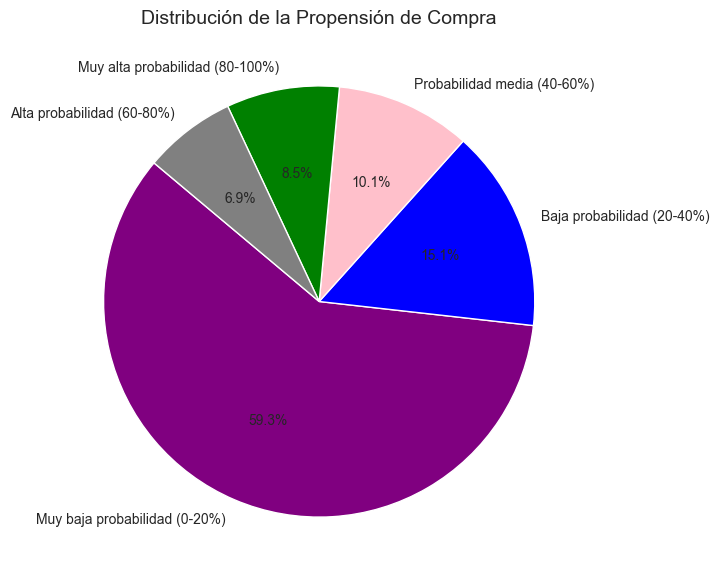

In [61]:

# Cargar datos
df = pd.read_csv("../data/Propensity_input.csv", index_col=0)

# Cargar modelo
modelo = joblib.load("../notebooks/models/best_xgboost_model.pkl")

# Asegurar que las columnas están en el mismo orden y convertir a float64
feature_names = modelo.get_booster().feature_names
df = df[feature_names].astype('float64')

# Hacer predicciones
df = df.copy()  # Evita SettingWithCopyWarning
df.loc[:, "Propension_Compra"] = modelo.predict_proba(df)[:, 1] * 100  # Convertimos a porcentaje

# Definir los nuevos rangos de propensión de compra
bins = [0, 20, 40, 60, 80, 100]
labels = [
    "Muy baja probabilidad (0-20%)",
    "Baja probabilidad (20-40%)",
    "Probabilidad media (40-60%)",
    "Alta probabilidad (60-80%)",
    "Muy alta probabilidad (80-100%)",
]

df.loc[:, "Segmento"] = pd.cut(df["Propension_Compra"], bins=bins, labels=labels, right=False)

# Calcular porcentaje de cada categoría
porcentajes = df["Segmento"].value_counts(normalize=True) * 100

# Configuración de colores (de mejor a peor)
colors = ["purple", "blue", "pink", "green", "grey"]

# Crear la gráfica de pastel
plt.figure(figsize=(7, 7))
plt.pie(
    porcentajes,
    labels=porcentajes.index,
    autopct="%1.1f%%",
    colors=colors,
    startangle=140,
)
plt.title("Distribución de la Propensión de Compra", fontsize=14)

# Mostrar el gráfico
plt.show()